In [1]:
import numpy as pd
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn import decomposition, ensemble
import textblob, string

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [2]:
df = pd.read_csv("../data/raw.csv")
df = df.set_index("id")

In [232]:
# drop null values
df = df.dropna()
df.isnull().sum()

title     0
author    0
text      0
label     0
length    0
dtype: int64

In [320]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

stop_words = set(stopwords.words("english"))
sanitised_df = df.copy()

for idx, row in sanitised_df.iterrows():
    review = re.sub("[^a-zA-Z]", " ", row["title"])
    review = re.sub("\s{2,}", " ", review)
    review = review.lower()
    review = review.split()
    review = list(filter(lambda word: word not in stop_words, review))
#     review = list(map(ps.stem, review))
    lemmatized = []
    for word in review:
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        lemmatized.append(lemmatizer.lemmatize(word, tag_dict.get(tag, wordnet.NOUN)))
    sanitised_df["title"][idx] = " ".join(lemmatized)

C:\Users\Aloysius\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [321]:
# remove
working_df = sanitised_df.copy()
working_df["length"] = working_df["title"].map(len)
working_df = working_df[(working_df["length"] >= 20) & (working_df["length"] <= 80)]
working_df.sort_values("length", ascending = False)

,title,author,text,label,length
id,,,,,
14704,playlist taylor swift jesus mary chain offer d...,"Jon Pareles, Jon Caramanica and Nate Chinen","Every Friday, pop critics for The New York Tim...",0,80
3465,fire white house staff claim see fence levee f...,Matthew Boyle,President Donald Trump’s White House communica...,0,80
4714,legislature reach deal extend mayoral control ...,Vivian Yee and Jesse McKinley,ALBANY — State lawmakers on Friday reached ...,0,80
10362,donald trump invite conservative medium white ...,Charlie Spiering,President Donald Trump met with a group of con...,0,80
2804,thursday even briefing golden state warrior hi...,Andrea Kannapell and Erica Ackerberg,(Want to get this briefing by email? Here’s th...,0,80
...,...,...,...,...,...
15611,another u false flag,Joachim Hagopian,"By Joachim Hagopian October 29, 2016 \r\nThe W...",1,20
7895,orphan new york time,Rachel Kushner,Standing at an intersection in Shuafat Refugee...,0,20
2025,would happen u nuked,EV,Ever wonder what would happen if the U.S. was ...,1,20


In [322]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    working_df["title"], 
    working_df["label"], 
    test_size = 0.25, 
    random_state = 0)

# Bag of Words

In [498]:
features = 8000
ngram = (1, 3)
mindf = 1

In [499]:
#bag of words with ngram for more meaning from the document
cv = CountVectorizer(ngram_range = ngram,
                     max_features = features,
                    min_df = mindf)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [500]:
X_train_cv_df = pd.DataFrame(X_train_cv.toarray(), columns = cv.get_feature_names())
top_words_df = pd.DataFrame(X_train_cv_df.sum()).sort_values(0, ascending=False)
top_words_df

,0
new,5121
time,4744
york,4656
new york,4655
york time,4578
...,...
ptsd new,3
ptsd new york,3
public faith,3
publicly,3


# TFIDF

In [501]:
#using TFIDF which down weights unimportant words that appear with high frequency
tv = TfidfVectorizer(
    max_features = features,
    ngram_range = ngram,
    min_df = mindf)
X_train_tv = tv.fit_transform(X_train)
X_test_tv = tv.transform(X_test)

In [502]:
X_train_tv_df = pd.DataFrame(X_train_tv.toarray(), columns = tv.get_feature_names())
top_words_df = pd.DataFrame(X_train_tv_df.sum()).sort_values(0, ascending=False)
top_words_df

,0
new,504.769285
time,480.499239
york,475.540986
new york,475.495310
york time,468.972417
...,...
line camp stand,0.649496
police prep assault,0.649496
police prep,0.649496
militarize police prep,0.649496


# Bernoulli Naive Bayes

In [503]:
m_model = MultinomialNB()
m_model.fit(pd.DataFrame(X_train_cv.toarray(), columns = cv.get_feature_names()), y_train)
pred = m_model.predict(pd.DataFrame(X_test_cv.toarray(), columns = cv.get_feature_names()))
print(accuracy_score(pred, y_test))

m_model.fit(pd.DataFrame(X_train_tv.toarray(), columns = tv.get_feature_names()), y_train)
pred = m_model.predict(pd.DataFrame(X_test_tv.toarray(), columns = tv.get_feature_names()))
print(accuracy_score(pred, y_test))

0.9124300656774508
0.878131841401119


In [504]:
b_model = BernoulliNB()
b_model.fit(pd.DataFrame(X_train_cv.toarray(), columns = cv.get_feature_names()), y_train)
pred = b_model.predict(pd.DataFrame(X_test_cv.toarray(), columns = cv.get_feature_names()))
print(accuracy_score(pred, y_test))

b_model.fit(pd.DataFrame(X_train_tv.toarray(), columns = tv.get_feature_names()), y_train)
pred = b_model.predict(pd.DataFrame(X_test_tv.toarray(), columns = tv.get_feature_names()))
print(accuracy_score(pred, y_test))

0.8946728289953783
0.8946728289953783


In [505]:
bow_accuracy_bnb = dict()
tfidf_accuracy_bnb = dict()

x = 100
for alpha_val in range(1, x + 1):
    alpha_val = alpha_val / x
    
    # Set Model
    model = MultinomialNB(alpha = alpha_val)

    # BOW
    model.fit(X_train_cv, y_train)
    bow_pred = model.predict(X_test_cv)
    bow_accuracy_bnb[alpha_val] = accuracy_score(y_test, bow_pred)

    # TFIDF
    model.fit(X_train_tv, y_train)
    bow_pred = model.predict(X_test_tv)
    tfidf_accuracy_bnb[alpha_val] = accuracy_score(y_test, bow_pred)

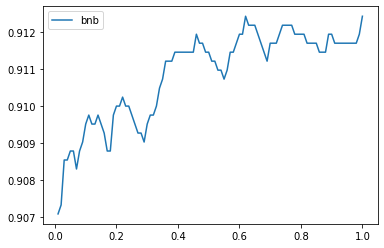

In [506]:
bow_acc_df = pd.DataFrame.from_dict(bow_accuracy_bnb, orient = "index", columns = ["bnb"])
# bow_acc_df["bnb_uniform_prior"] = bow_accuracy_bnb_uniform_prior.values()
sns.lineplot(data = bow_acc_df)

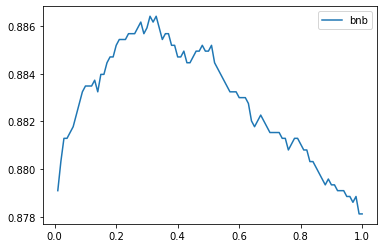

In [507]:
tfidf_acc_df = pd.DataFrame.from_dict(tfidf_accuracy_bnb, orient = "index", columns = ["bnb"])
# tfidf_acc_df["bnb_uniform_prior"] = tfidf_accuracy_bnb_uniform_prior.values()
sns.lineplot(data = tfidf_acc_df)

In [508]:
max_bow_key = max(bow_accuracy_bnb, key = bow_accuracy_bnb.get)
print(max_bow_key, bow_accuracy_bnb[max_bow_key])
max_tfidf_key = max(tfidf_accuracy_bnb, key = tfidf_accuracy_bnb.get)
print(max_tfidf_key, tfidf_accuracy_bnb[max_tfidf_key])

0.62 0.9124300656774508
0.31 0.8864023351982486
